In [1]:

import pickle
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
import seaborn as sns

from sklearn.svm import SVC
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import cohen_kappa_score, classification_report
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import label_binarize
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA

In [2]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Combine X_train and X_valid
X_train = np.concatenate((X_train, X_valid), axis=0)

# Combine y_train and y_valid
y_train = np.concatenate((y_train, y_valid), axis=0)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (5752, 224, 224, 3)
y_train shape: (5752,)
X_test shape: (1440, 224, 224, 3)
y_test shape: (1440,)


In [4]:
# Define the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)  # Adjusted to 8x8 for larger images
cells_per_block = (2, 2)  # Adjusted to 2x2 for larger images

# Function to extract HOG features from a single color image
def extract_features(img):
    # Compute HOG features for each color channel separately
    hog_features = []
    for channel in range(img.shape[2]):
        features = hog(img[:, :, channel], orientations=orientations,
                        pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block,
                        visualize=False,
                        transform_sqrt=True,
                        feature_vector=True,
                        block_norm='L2-Hys')
        hog_features.extend(features)
    return np.array(hog_features)

# Apply the extract_features function to all images in X_train and X_test
X_train_features = np.array([extract_features(img) for img in X_train])
X_test_features = np.array([extract_features(img) for img in X_test])

print(f"X_train_features Shape: {X_train_features.shape}")
print(f"X_test_features Shape: {X_test_features.shape}")


X_train_features Shape: (5752, 78732)
X_test_features Shape: (1440, 78732)


In [7]:
# Number of principal components (you can adjust this based on your needs)
n_components = 100

# Initialize PCA with the desired number of components
pca = PCA(n_components=n_components)

# Fit and transform the PCA on the HOG features of the training and test data
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

print(f"X_train_pca Shape: {X_train_pca.shape}")
print(f"X_test_pca Shape: {X_test_pca.shape}")


X_train_pca Shape: (5752, 100)
X_test_pca Shape: (1440, 100)


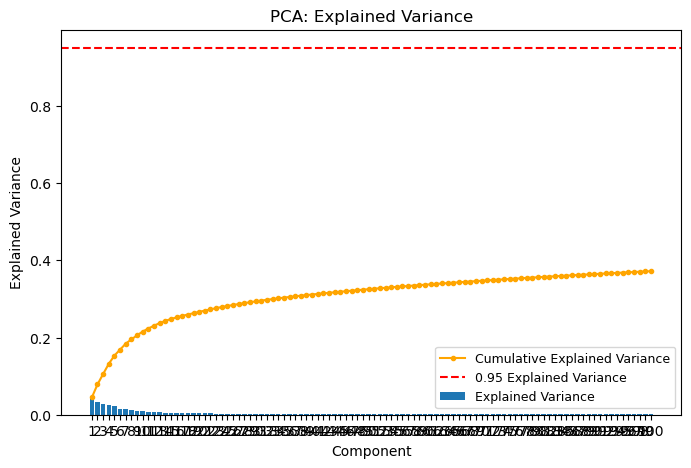

In [8]:
#getting explained variance ratio from the lda model 
evr = pca.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('PCA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

Text(0, 0.5, 'Linear Discriminant 2')

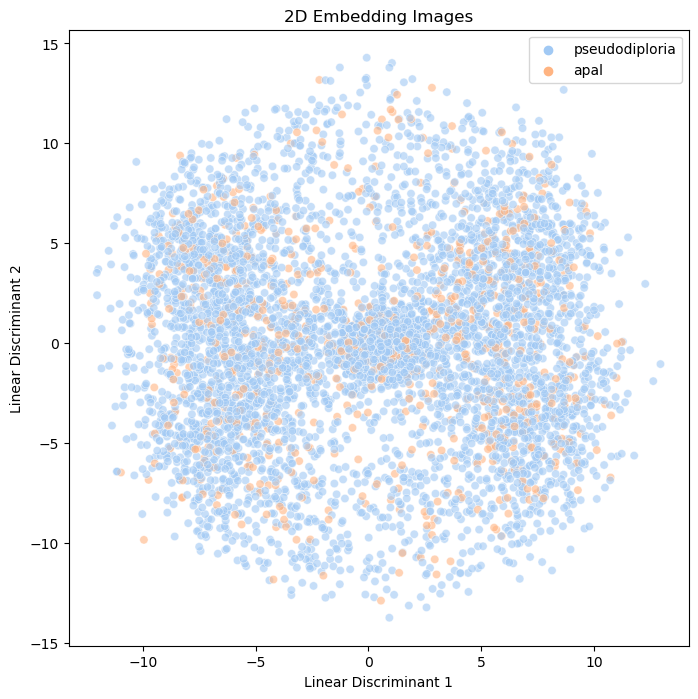

In [24]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_pca[:,0], y = X_train_pca[:,1], hue = y_train, palette = 'pastel',alpha=.6);
handler, _ = ax.get_legend_handles_labels();
letters = ["pseudodiploria",'apal']

plt.legend(handler, letters, bbox_to_anchor=(1, 1))
plt.title('2D Embedding Images')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')


In [25]:
#defining support vector machine parameters
parameters = {
    'kernel':['linear','poly','rbf','sigmoid'], 
    'gamma':['scale','auto'],
    'C':np.linspace(0.01,.75,5)
    }

#defining randomized grid search cv
clf = RandomizedSearchCV(SVC(),param_distributions=parameters,random_state=99,verbose=3)
#fitting to LDA transformed training data 
search_lda = clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.862 total time=   1.5s
[CV 2/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.862 total time=   1.5s
[CV 3/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.863 total time=   1.0s
[CV 4/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.863 total time=   1.5s
[CV 5/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.862 total time=   1.5s
[CV 1/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.862 total time=   3.5s
[CV 2/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.862 total time=   3.3s
[CV 3/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.863 total time=   3.3s
[CV 4/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.863 total time=   3.7s
[CV 5/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.863 total time=   3.4s
[CV 1/5] END ..C=0.565, gamma=auto, kernel=poly;, score=0.840 total time=   1.4s
[CV 2/5] END ..C=0.565, gamma=auto, kernel=poly;

In [26]:
#best model
search_lda.best_params_

{'kernel': 'linear', 'gamma': 'auto', 'C': 0.75}

In [3]:
# 3. Training: Train an SVM classifier
svm_classifier = SVC(kernel='linear',gamma='auto', C=0.75, random_state=42)
svm_classifier.fit(X_train_pca, y_train)

NameError: name 'X_train_pca' is not defined

In [ ]:
# 5. Testing
y_train_pred = svm_classifier.predict(X_train_features)
train_accuracy = accuracy_score(y_train, y_train_pred)
print(f"Train Accuracy: {train_accuracy * 100:.2f}%")

y_test_pred = svm_classifier.predict(X_test_features)
test_accuracy = accuracy_score(y_test, y_test_pred)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

Train Accuracy: 86.23%
Test Accuracy: 90.00%


In [ ]:
# Make predictions on the test data
y_pred = svm_classifier.predict(X_test_features)

# Get the class labels
labels = list(set(y_train))

# Classification report
report = classification_report(y_test, y_pred, target_names=labels)
print("Classification report:")
print(report)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("Confusion Matrix:")
print(cm)

Cohen's Kappa: 0.0
Classification report:
                precision    recall  f1-score   support

pseudodiploria       0.00      0.00      0.00       144
          apal       0.90      1.00      0.95      1296

      accuracy                           0.90      1440
     macro avg       0.45      0.50      0.47      1440
  weighted avg       0.81      0.90      0.85      1440

Confusion Matrix:
[[   0  144]
 [   0 1296]]


/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

In [ ]:
# Step 2: Evaluate the model on the test data (replace with your model and test data)
y_true = y_test  # Replace with your true labels
y_pred = svm_classifier.predict(X_test_features)  # Replace with your model predictions

# Calculate accuracy
accuracy = accuracy_score(y_true, y_pred)
print("Accuracy of the model is:", accuracy * 100, "%")

# Step 4: Generate a classification report
report = classification_report(y_true, y_pred)
print("Classification Report:")
print(report)


Accuracy of the model is: 90.0 %
Cohen's Kappa: 0.0
Classification Report:
                precision    recall  f1-score   support

          apal       0.00      0.00      0.00       144
pseudodiploria       0.90      1.00      0.95      1296

      accuracy                           0.90      1440
     macro avg       0.45      0.50      0.47      1440
  weighted avg       0.81      0.90      0.85      1440



/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/sumaiyauddin/opt/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result)

### SVM with balanced data

In [4]:
# Load the augmented data from the saved file
data = np.load('../data/external/coral_augmented_combined_bl_v2.npz')

# Access the arrays from the loaded data
X_train = data['X_train']
y_train = data['y_train']
X_test = data['X_test']
y_test = data['y_test']
X_valid = data['X_valid']
y_valid = data['y_valid']

# Combine X_train and X_valid
X_train = np.concatenate((X_train, X_valid), axis=0)

# Combine y_train and y_valid
y_train = np.concatenate((y_train, y_valid), axis=0)

# Print the shapes to verify
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (9496, 224, 224, 3)
y_train shape: (9496,)
X_test shape: (2376, 224, 224, 3)
y_test shape: (2376,)


In [5]:
# Define the HOG parameters
orientations = 9
pixels_per_cell = (8, 8)  # Adjusted to 8x8 for larger images
cells_per_block = (2, 2)  # Adjusted to 2x2 for larger images

# Function to extract HOG features from a single color image
def extract_features(img):
    # Compute HOG features for each color channel separately
    hog_features = []
    for channel in range(img.shape[2]):
        features = hog(img[:, :, channel], orientations=orientations,
                        pixels_per_cell=pixels_per_cell,
                        cells_per_block=cells_per_block,
                        visualize=False,
                        transform_sqrt=True,
                        feature_vector=True,
                        block_norm='L2-Hys')
        hog_features.extend(features)
    return np.array(hog_features)

# Apply the extract_features function to all images in X_train and X_test
X_train_features = np.array([extract_features(img) for img in X_train])
X_test_features = np.array([extract_features(img) for img in X_test])

print(f"X_train_features Shape: {X_train_features.shape}")
print(f"X_test_features Shape: {X_test_features.shape}")


X_train_features Shape: (9496, 78732)
X_test_features Shape: (2376, 78732)


In [6]:
import pickle

# Save HOG features to a pickle file
with open('hog_features.pkl', 'wb') as f:
    pickle.dump((X_train_features, X_test_features, y_train, y_test), f)

In [8]:
import pickle

# Load the HOG features from the pickle file
with open('hog_features.pkl', 'rb') as f:
    X_train_features, X_test_features, y_train, y_test = pickle.load(f)


In [29]:
from sklearn.decomposition import PCA

# Number of principal components (you can adjust this based on your needs)
n_components = 50

# Initialize PCA with the desired number of components
pca = PCA(n_components=n_components)

# Fit and transform the PCA on the HOG features of the training and test data
X_train_pca = pca.fit_transform(X_train_features)
X_test_pca = pca.transform(X_test_features)

print(f"X_train_pca Shape: {X_train_pca.shape}")
print(f"X_test_pca Shape: {X_test_pca.shape}")


X_train_pca Shape: (9496, 50)
X_test_pca Shape: (2376, 50)


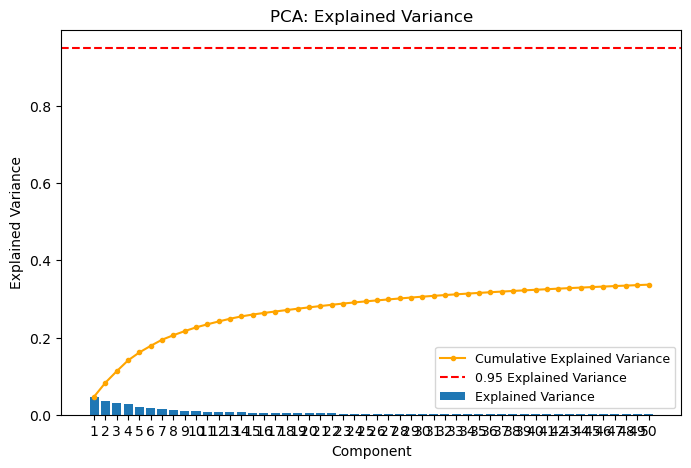

In [30]:
#getting explained variance ratio from the lda model 
evr = pca.explained_variance_ratio_
components = range(1, len(evr) + 1)

#plotting scree plot
fig, ax = plt.subplots(figsize = (8,5))
ax.bar(x = components, height = evr, label = 'Explained Variance');
plt.plot(components, np.cumsum(evr), marker = '.', color = 'orange', label = 'Cumulative Explained Variance')
plt.axhline(y = .95, color = 'r', linestyle = '--', label = '0.95 Explained Variance')
plt.xticks(range(1, len(evr)+1));
plt.title('PCA: Explained Variance');
plt.xlabel('Component');
plt.ylabel('Explained Variance');
plt.legend(fontsize = 9);

Text(0, 0.5, 'Linear Discriminant 2')

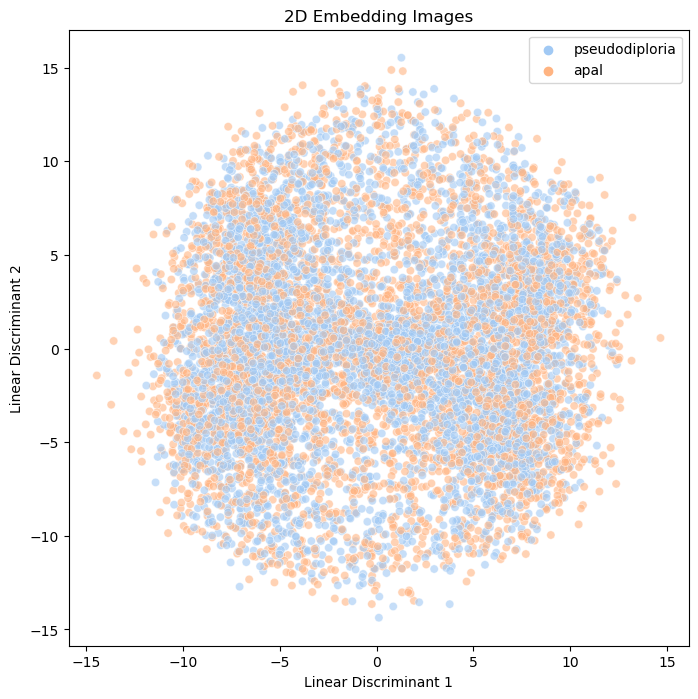

In [31]:
import seaborn as sns

fig, ax = plt.subplots(figsize = (8,8))
ax = sns.scatterplot(x = X_train_pca[:,0], y = X_train_pca[:,1], hue = y_train, palette = 'pastel',alpha=.6);
handler, _ = ax.get_legend_handles_labels();
letters = ["pseudodiploria",'apal']

plt.legend(handler, letters, bbox_to_anchor=(1, 1))
plt.title('2D Embedding Images')
plt.xlabel('Linear Discriminant 1')
plt.ylabel('Linear Discriminant 2')


In [32]:
#defining support vector machine parameters
parameters = {
    'kernel':['linear','poly','rbf','sigmoid'], 
    'gamma':['scale','auto'],
    'C':np.linspace(0.01,.75,5)
    }

#defining randomized grid search cv
clf = RandomizedSearchCV(SVC(),param_distributions=parameters,random_state=99,verbose=3)
#fitting to LDA transformed training data 
search_svm = clf.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.623 total time=   3.1s
[CV 2/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.725 total time=   2.9s
[CV 3/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.725 total time=   3.0s
[CV 4/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.740 total time=   3.4s
[CV 5/5] END .C=0.565, gamma=scale, kernel=poly;, score=0.696 total time=   4.4s
[CV 1/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.671 total time=  16.0s
[CV 2/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.687 total time=  15.7s
[CV 3/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.689 total time=  15.3s
[CV 4/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.715 total time=  15.2s
[CV 5/5] END .C=0.75, gamma=auto, kernel=linear;, score=0.706 total time=  15.4s
[CV 1/5] END ..C=0.565, gamma=auto, kernel=poly;, score=0.753 total time=  10.0s
[CV 2/5] END ..C=0.565, gamma=auto, kernel=poly;

In [33]:
#dumping randomized search cv into pickle file 
with open('../data/external/svm_randomized_search_cv.pkl','wb') as f:
  pickle.dump(search_svm,f)

In [34]:
#best model
search_svm.best_params_

{'kernel': 'rbf', 'gamma': 'scale', 'C': 0.565}

In [35]:
# 3. Training: Train an SVM classifier
svm_classifier = SVC(kernel='rbf',gamma='scale', C=0.565, random_state=42)
svm_classifier.fit(X_train_pca, y_train)

SVC(C=0.565, random_state=42)

Training Accuracy of the model is: 79.92839090143218 %
Tesing Accuracy of the model is: 73.61111111111111 %
Testing Classification Report:
                precision    recall  f1-score   support

          APAL       0.80      0.68      0.74      1288
Pseudodiploria       0.68      0.80      0.74      1088

      accuracy                           0.74      2376
     macro avg       0.74      0.74      0.74      2376
  weighted avg       0.75      0.74      0.74      2376



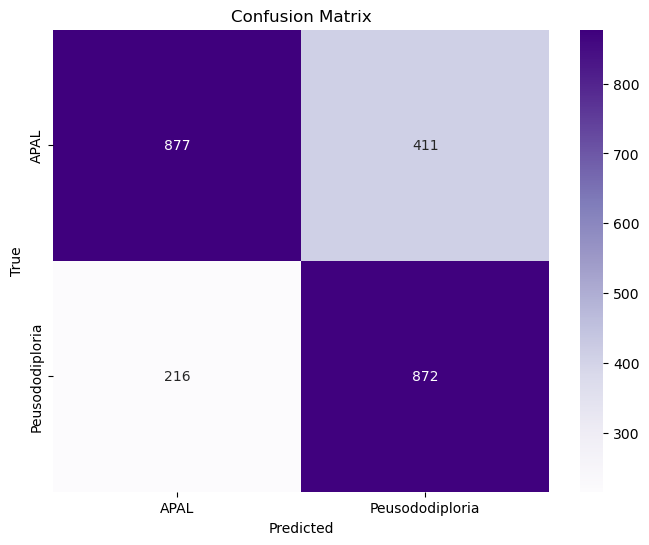

In [36]:
# predicting test
y_pred_test = svm_classifier.predict(X_test_pca)  # Replace with your model predictions
y_pred_train = svm_classifier.predict(X_train_pca)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy of the model is:", accuracy * 100, "%")
accuracy = accuracy_score(y_test, y_pred_test)
print("Tesing Accuracy of the model is:", accuracy * 100, "%")

# Generate a classification report
report = classification_report(y_test, y_pred_test)
print("Testing Classification Report:")
print(report)

# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

## Random forest

In [37]:
n_estimators = np.arange(2,22,2)
max_depth = np.arange(2,22,2)
param_grid = {
    'n_estimators': n_estimators,
    'max_depth': max_depth,
    'min_samples_split': [10, 20, 30],
    'min_samples_leaf': [5, 10, 15],
    'max_features': [5, 10, 15]
}

# Create a Random Forest classifier object
rfc = RandomForestClassifier()

# Create a RandomizedSearchCV object
rfc_search = RandomizedSearchCV(estimator = rfc,
                                param_distributions = param_grid,
                                cv = 5, 
                                random_state=42,
                                verbose=3)


# Fit the RandomizedSearchCV object to the data
rfc_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.614 total time=   0.1s
[CV 2/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.591 total time=   0.0s
[CV 3/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.609 total time=   0.0s
[CV 4/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.601 total time=   0.1s
[CV 5/5] END max_depth=8, max_features=5, min_samples_leaf=10, min_samples_split=30, n_estimators=2;, score=0.617 total time=   0.0s
[CV 1/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.664 total time=   1.0s
[CV 2/5] END max_depth=10, max_features=15, min_samples_leaf=10, min_samples_split=10, n_estimators=10;, score=0.677 total time=   0.9s
[C

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(),
                   param_distributions={'max_depth': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20]),
                                        'max_features': [5, 10, 15],
                                        'min_samples_leaf': [5, 10, 15],
                                        'min_samples_split': [10, 20, 30],
                                        'n_estimators': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18, 20])},
                   random_state=42, verbose=3)

In [38]:
# Print the best hyperparameters
print(rfc_search.best_params_)

{'n_estimators': 18, 'min_samples_split': 10, 'min_samples_leaf': 15, 'max_features': 10, 'max_depth': 10}


In [39]:
#dumping randomized search cv into pickle file 
with open('../data/external/rfc_randomized_search_cv.pkl','wb') as f:
  pickle.dump(rfc_search,f)

In [40]:
#defining rfc with best parameters
rfc =RandomForestClassifier(n_estimators=18, min_samples_split=10, min_samples_leaf=15, 
                                   max_features=10, max_depth=10, random_state=42)

rfc.fit(X_train_pca, y_train)

RandomForestClassifier(max_depth=10, max_features=10, min_samples_leaf=15,
                       min_samples_split=10, n_estimators=18, random_state=42)

Training Accuracy of the model is: 83.6352148272957 %
Tesing Accuracy of the model is: 65.40404040404042 %
Testing Classification Report:
                precision    recall  f1-score   support

          APAL       0.74      0.56      0.64      1288
Pseudodiploria       0.60      0.76      0.67      1088

      accuracy                           0.65      2376
     macro avg       0.67      0.66      0.65      2376
  weighted avg       0.67      0.65      0.65      2376



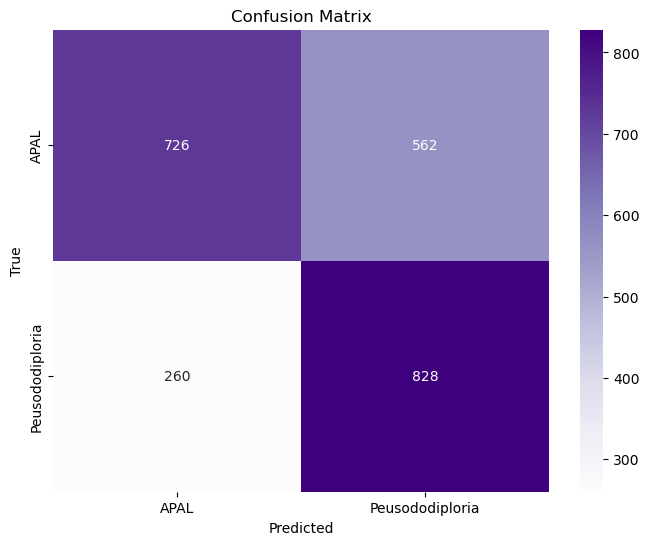

In [41]:
# predicting test
y_pred_test = rfc.predict(X_test_pca)  # Replace with your model predictions
y_pred_train = rfc.predict(X_train_pca)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy of the model is:", accuracy * 100, "%")
accuracy = accuracy_score(y_test, y_pred_test)
print("Tesing Accuracy of the model is:", accuracy * 100, "%")

# Generate a classification report
report = classification_report(y_test, y_pred_test)
print("Testing Classification Report:")
print(report)

# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

### Logistic Regression

In [42]:
from scipy.stats import uniform
lr = LogisticRegression()

max_iter = range(5000)
solver = ['lbfgs', 'newton-cg', 'liblinear']
warm_start = [True, False]
C = uniform(loc=0, scale=4)
penalty = ["l1", "l2"]
random_grid ={
    'max_iter' : max_iter,
    'warm_start' : warm_start,
    'solver' : solver,
    'C' : C,
    'penalty' : penalty,
}

lr_search = RandomizedSearchCV(estimator = lr,
                                   param_distributions = random_grid,
                                   scoring = 'accuracy',
                                   verbose = 3, 
                                   random_state = 42,
                                  )

lr_search.fit(X_train_pca, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV 1/5] END C=1.49816047538945, max_iter=860, penalty=l1, solver=liblinear, warm_start=False;, score=0.675 total time=   0.1s
[CV 2/5] END C=1.49816047538945, max_iter=860, penalty=l1, solver=liblinear, warm_start=False;, score=0.686 total time=   0.1s
[CV 3/5] END C=1.49816047538945, max_iter=860, penalty=l1, solver=liblinear, warm_start=False;, score=0.690 total time=   0.0s
[CV 4/5] END C=1.49816047538945, max_iter=860, penalty=l1, solver=liblinear, warm_start=False;, score=0.719 total time=   0.0s
[CV 5/5] END C=1.49816047538945, max_iter=860, penalty=l1, solver=liblinear, warm_start=False;, score=0.706 total time=   0.0s
[CV 1/5] END C=2.3946339367881464, max_iter=466, penalty=l1, solver=liblinear, warm_start=True;, score=0.675 total time=   0.1s
[CV 2/5] END C=2.3946339367881464, max_iter=466, penalty=l1, solver=liblinear, warm_start=True;, score=0.685 total time=   0.1s
[CV 3/5] END C=2.3946339367881464, max_iter=466,

/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=0.22564631610840102, max_iter=2391, penalty=l2, solver=newton-cg, warm_start=False;, score=0.674 total time=   1.7s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.22564631610840102, max_iter=2391, penalty=l2, solver=newton-cg, warm_start=False;, score=0.684 total time=   1.0s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 3/5] END C=0.22564631610840102, max_iter=2391, penalty=l2, solver=newton-cg, warm_start=False;, score=0.690 total time=   2.2s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=0.22564631610840102, max_iter=2391, penalty=l2, solver=newton-cg, warm_start=False;, score=0.719 total time=   1.1s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.22564631610840102, max_iter=2391, penalty=l2, solver=newton-cg, warm_start=False;, score=0.706 total time=   2.5s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 1/5] END C=0.0031150633640573133, max_iter=1184, penalty=l2, solver=newton-cg, warm_start=False;, score=0.662 total time=   1.7s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 2/5] END C=0.0031150633640573133, max_iter=1184, penalty=l2, solver=newton-cg, warm_start=False;, score=0.681 total time=   0.7s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 3/5] END C=0.0031150633640573133, max_iter=1184, penalty=l2, solver=newton-cg, warm_start=False;, score=0.694 total time=   0.8s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 4/5] END C=0.0031150633640573133, max_iter=1184, penalty=l2, solver=newton-cg, warm_start=False;, score=0.722 total time=   2.7s


/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/scipy/optimize/_linesearch.py:306: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)
/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/utils/optimize.py:203: UserWarning: Line Search failed
  warnings.warn("Line Search failed")


[CV 5/5] END C=0.0031150633640573133, max_iter=1184, penalty=l2, solver=newton-cg, warm_start=False;, score=0.701 total time=   0.7s
[CV 1/5] END C=0.028265220878869624, max_iter=2904, penalty=l1, solver=liblinear, warm_start=True;, score=0.671 total time=   0.1s
[CV 2/5] END C=0.028265220878869624, max_iter=2904, penalty=l1, solver=liblinear, warm_start=True;, score=0.682 total time=   0.0s
[CV 3/5] END C=0.028265220878869624, max_iter=2904, penalty=l1, solver=liblinear, warm_start=True;, score=0.696 total time=   0.0s
[CV 4/5] END C=0.028265220878869624, max_iter=2904, penalty=l1, solver=liblinear, warm_start=True;, score=0.722 total time=   0.0s
[CV 5/5] END C=0.028265220878869624, max_iter=2904, penalty=l1, solver=liblinear, warm_start=True;, score=0.700 total time=   0.0s
[CV 1/5] END C=1.599443886861022, max_iter=2047, penalty=l2, solver=liblinear, warm_start=False;, score=0.675 total time=   0.0s
[CV 2/5] END C=1.599443886861022, max_iter=2047, penalty=l2, solver=liblinear, warm

/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
5 fits failed out of a total of 50.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
5 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sumaiyauddin/opt/anaconda3/envs/tensorflow_tf/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/Users/sumaiyauddin/

RandomizedSearchCV(estimator=LogisticRegression(),
                   param_distributions={'C': <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x7ff27841cfd0>,
                                        'max_iter': range(0, 5000),
                                        'penalty': ['l1', 'l2'],
                                        'solver': ['lbfgs', 'newton-cg',
                                                   'liblinear'],
                                        'warm_start': [True, False]},
                   random_state=42, scoring='accuracy', verbose=3)

In [43]:
print('Best hyperparameters:', lr_search.best_params_)
print('Best score:', lr_search.best_score_)

Best hyperparameters: {'C': 0.3624257381312832, 'max_iter': 3005, 'penalty': 'l1', 'solver': 'liblinear', 'warm_start': False}
Best score: 0.6954528976469609


In [44]:
#dumping randomized search cv into pickle file 
with open('../data/external/lr_randomized_search_cv.pkl','wb') as f:
  pickle.dump(lr_search,f)

In [45]:
lr = LogisticRegression(C=.028265220878869624,
                        max_iter=2904, 
                        penalty="l1", 
                        solver='liblinear',
                        warm_start=True)
lr.fit(X_train_pca, y_train)


LogisticRegression(C=0.028265220878869624, max_iter=2904, penalty='l1',
                   solver='liblinear', warm_start=True)

Training Accuracy of the model is: 71.15627632687446 %
Tesing Accuracy of the model is: 69.78114478114477 %
Testing Classification Report:
                precision    recall  f1-score   support

          APAL       0.76      0.64      0.70      1288
Pseudodiploria       0.64      0.76      0.70      1088

      accuracy                           0.70      2376
     macro avg       0.70      0.70      0.70      2376
  weighted avg       0.71      0.70      0.70      2376



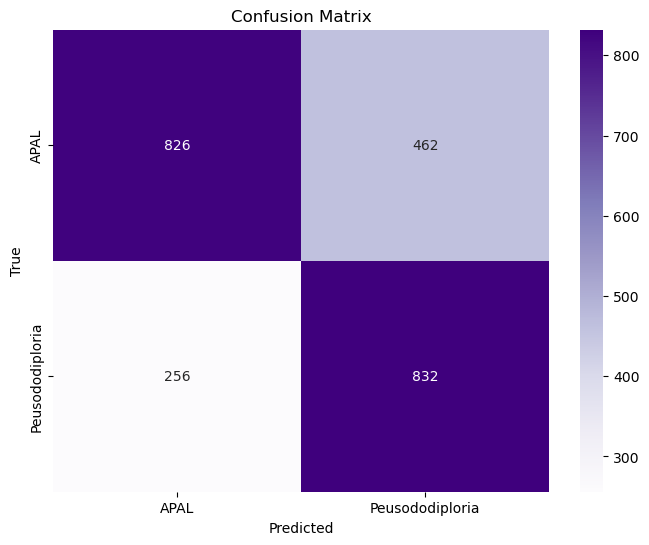

In [46]:
# predicting test
y_pred_test = lr.predict(X_test_pca)  # Replace with your model predictions
y_pred_train = lr.predict(X_train_pca)

# Calculate accuracy
accuracy = accuracy_score(y_train, y_pred_train)
print("Training Accuracy of the model is:", accuracy * 100, "%")
accuracy = accuracy_score(y_test, y_pred_test)
print("Tesing Accuracy of the model is:", accuracy * 100, "%")

# Generate a classification report
report = classification_report(y_test, y_pred_test)
print("Testing Classification Report:")
print(report)

# Define class labels (replace these with your actual class labels)
class_labels = ['APAL', 'Peusododiploria']

cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Purples', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()